# 1. Imports

In [3]:

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor


# 2. Data Loading

In [4]:

files = [
    "./input/2022.csv",
    "./input/2023.csv",
    "./input/2024.csv"
]
dfs = [pd.read_csv(f, low_memory=False) for f in files]
dfs


[       ResponseId                                         MainBranch  \
 0               1                                      None of these   
 1               2                     I am a developer by profession   
 2               3  I am not primarily a developer, but I write co...   
 3               4                     I am a developer by profession   
 4               5                     I am a developer by profession   
 ...           ...                                                ...   
 73263       73264                     I am a developer by profession   
 73264       73265                     I am a developer by profession   
 73265       73266  I am not primarily a developer, but I write co...   
 73266       73267                     I am a developer by profession   
 73267       73268  I used to be a developer by profession, but no...   
 
                                               Employment  \
 0                                                    NaN   


# 3. Initial Exploration

In [5]:

for i, df in enumerate(dfs, 2022):
    print(f"Dataset {i} shape: {df.shape}")
    print(df.columns.tolist())
    print('-'*80)


Dataset 2022 shape: (73268, 79)
['ResponseId', 'MainBranch', 'Employment', 'RemoteWork', 'CodingActivities', 'EdLevel', 'LearnCode', 'LearnCodeOnline', 'LearnCodeCoursesCert', 'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize', 'PurchaseInfluence', 'BuyNewTool', 'Country', 'Currency', 'CompTotal', 'CompFreq', 'LanguageHaveWorkedWith', 'LanguageWantToWorkWith', 'DatabaseHaveWorkedWith', 'DatabaseWantToWorkWith', 'PlatformHaveWorkedWith', 'PlatformWantToWorkWith', 'WebframeHaveWorkedWith', 'WebframeWantToWorkWith', 'MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith', 'ToolsTechHaveWorkedWith', 'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith', 'NEWCollabToolsWantToWorkWith', 'OpSysProfessional use', 'OpSysPersonal use', 'VersionControlSystem', 'VCInteraction', 'VCHostingPersonal use', 'VCHostingProfessional use', 'OfficeStackAsyncHaveWorkedWith', 'OfficeStackAsyncWantToWorkWith', 'OfficeStackSyncHaveWorkedWith', 'OfficeStackSyncWantToWorkWith', 'Blockchain', 'NEWSOSites', 'SOVisitF

# 4. Data Preprocessing

In [6]:

# Functions to clean data
def select_and_rename(df):
    cols = ["Country", "EdLevel", "YearsCodePro", "Employment", "ConvertedCompYearly", "DevType", "Age", "OrgSize", "RemoteWork"]
    df = df[[c for c in cols if c in df.columns]].copy()
    df.rename(columns={
        "ConvertedCompYearly": "Salary",
        "YearsCodePro": "YearsExperience",
        "EdLevel": "EducationLevel",
        "DevType": "DeveloperType",
        "OrgSize": "CompanySize"
    }, inplace=True)
    return df

def clean_employment(x):
    if isinstance(x, str):
        x = x.lower()
        if 'full-time' in x:
            return 'Full-time'
        if 'part-time' in x:
            return 'Part-time'
        if 'self-employed' in x or 'freelance' in x:
            return 'Self-employed'
    return 'Other'

def clean_education(x):
    if isinstance(x, str):
        x = x.lower()
        if 'bachelor' in x:
            return "Bachelor's"
        if 'master' in x:
            return "Master's"
        if 'ph.d' in x or 'doctoral' in x or 'professional' in x:
            return "Postgrad"
    return "Less than Bachelor's"

def clean_dev_type(x):
    if isinstance(x, str):
        x = x.lower()
        if 'full-stack' in x:
            return 'Full-stack'
        if 'back-end' in x:
            return 'Back-end'
        if 'front-end' in x:
            return 'Front-end'
        if 'data scientist' in x or 'machine learning' in x:
            return 'Data Scientist'
        if 'devops' in x:
            return 'DevOps'
    return 'Other'

def clean_company_size(x):
    if isinstance(x, str):
        if '1-9' in x or '1 to 9' in x:
            return 'Small (1-9)'
        if '10-99' in x:
            return 'Medium (10-99)'
        if '100-999' in x:
            return 'Large (100-999)'
        if '1000+' in x or '1,000' in x:
            return 'Enterprise (1000+)'
    return 'Unknown'

def clean_experience(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str):
        if 'less than 1' in x.lower():
            return 0.5
        if 'more than 50' in x.lower():
            return 50
        try:
            return float(x.split()[0])
        except:
            return np.nan
    return float(x)

def preprocess(df, country_cutoff=200):
    df = select_and_rename(df)
    df = df[df['Salary'].notna()]
    df['Employment'] = df['Employment'].apply(clean_employment)
    df = df[df['Employment'] == 'Full-time']
    df['EducationLevel'] = df['EducationLevel'].apply(clean_education)
    if 'DeveloperType' in df.columns:
        df['DeveloperType'] = df['DeveloperType'].apply(clean_dev_type)
    if 'CompanySize' in df.columns:
        df['CompanySize'] = df['CompanySize'].apply(clean_company_size)
    df['YearsExperience'] = df['YearsExperience'].apply(clean_experience)
    df['YearsExperience'] = df['YearsExperience'].fillna(df['YearsExperience'].median())
    country_counts = df['Country'].value_counts()
    df['Country'] = df['Country'].apply(lambda x: x if country_counts.get(x, 0) >= country_cutoff else 'Other')
    df = df[df['Country'] != 'Other']
    salary_q1 = df['Salary'].quantile(0.05)
    salary_q3 = df['Salary'].quantile(0.95)
    df = df[(df['Salary'] > salary_q1) & (df['Salary'] < salary_q3)]
    df['LogSalary'] = np.log1p(df['Salary'])
    df['ExpSquared'] = df['YearsExperience'] ** 2
    return df


In [7]:

dfs = [preprocess(df) for df in dfs]
data = pd.concat(dfs, ignore_index=True)
data.to_csv("./output/merged_cleaned_salary_data.csv", index=False)
data.head()


,Country,EducationLevel,YearsExperience,Employment,Salary,DeveloperType,Age,CompanySize,RemoteWork,LogSalary,ExpSquared
0,United Kingdom of Great Britain and Northern I...,Master's,5.0,Full-time,40205.0,Front-end,25-34 years old,Unknown,"Hybrid (some remote, some in-person)",10.601772,25.0
1,Israel,Bachelor's,17.0,Full-time,215232.0,Full-stack,35-44 years old,Unknown,Fully remote,12.279476,289.0
2,Netherlands,Master's,6.0,Full-time,49056.0,Back-end,25-34 years old,Unknown,"Hybrid (some remote, some in-person)",10.800738,36.0
3,United Kingdom of Great Britain and Northern I...,Bachelor's,2.0,Full-time,60307.0,Full-stack,18-24 years old,Unknown,"Hybrid (some remote, some in-person)",11.007220,4.0
4,United States of America,Bachelor's,10.0,Full-time,194400.0,Other,35-44 years old,Unknown,Fully remote,12.177678,100.0


# 5. Exploratory Data Analysis (EDA)

**Deepseek**

Index(['Country', 'EducationLevel', 'YearsExperience', 'Employment', 'Salary',
       'DeveloperType', 'Age', 'CompanySize', 'RemoteWork', 'LogSalary',
       'ExpSquared'],
      dtype='object')
Dataset contains 75499 rows and 11 columns

Missing values per column:
Country             0
EducationLevel      0
YearsExperience     0
Employment          0
Salary              0
DeveloperType       0
Age                59
CompanySize         0
RemoteWork          2
LogSalary           0
ExpSquared          0
dtype: int64


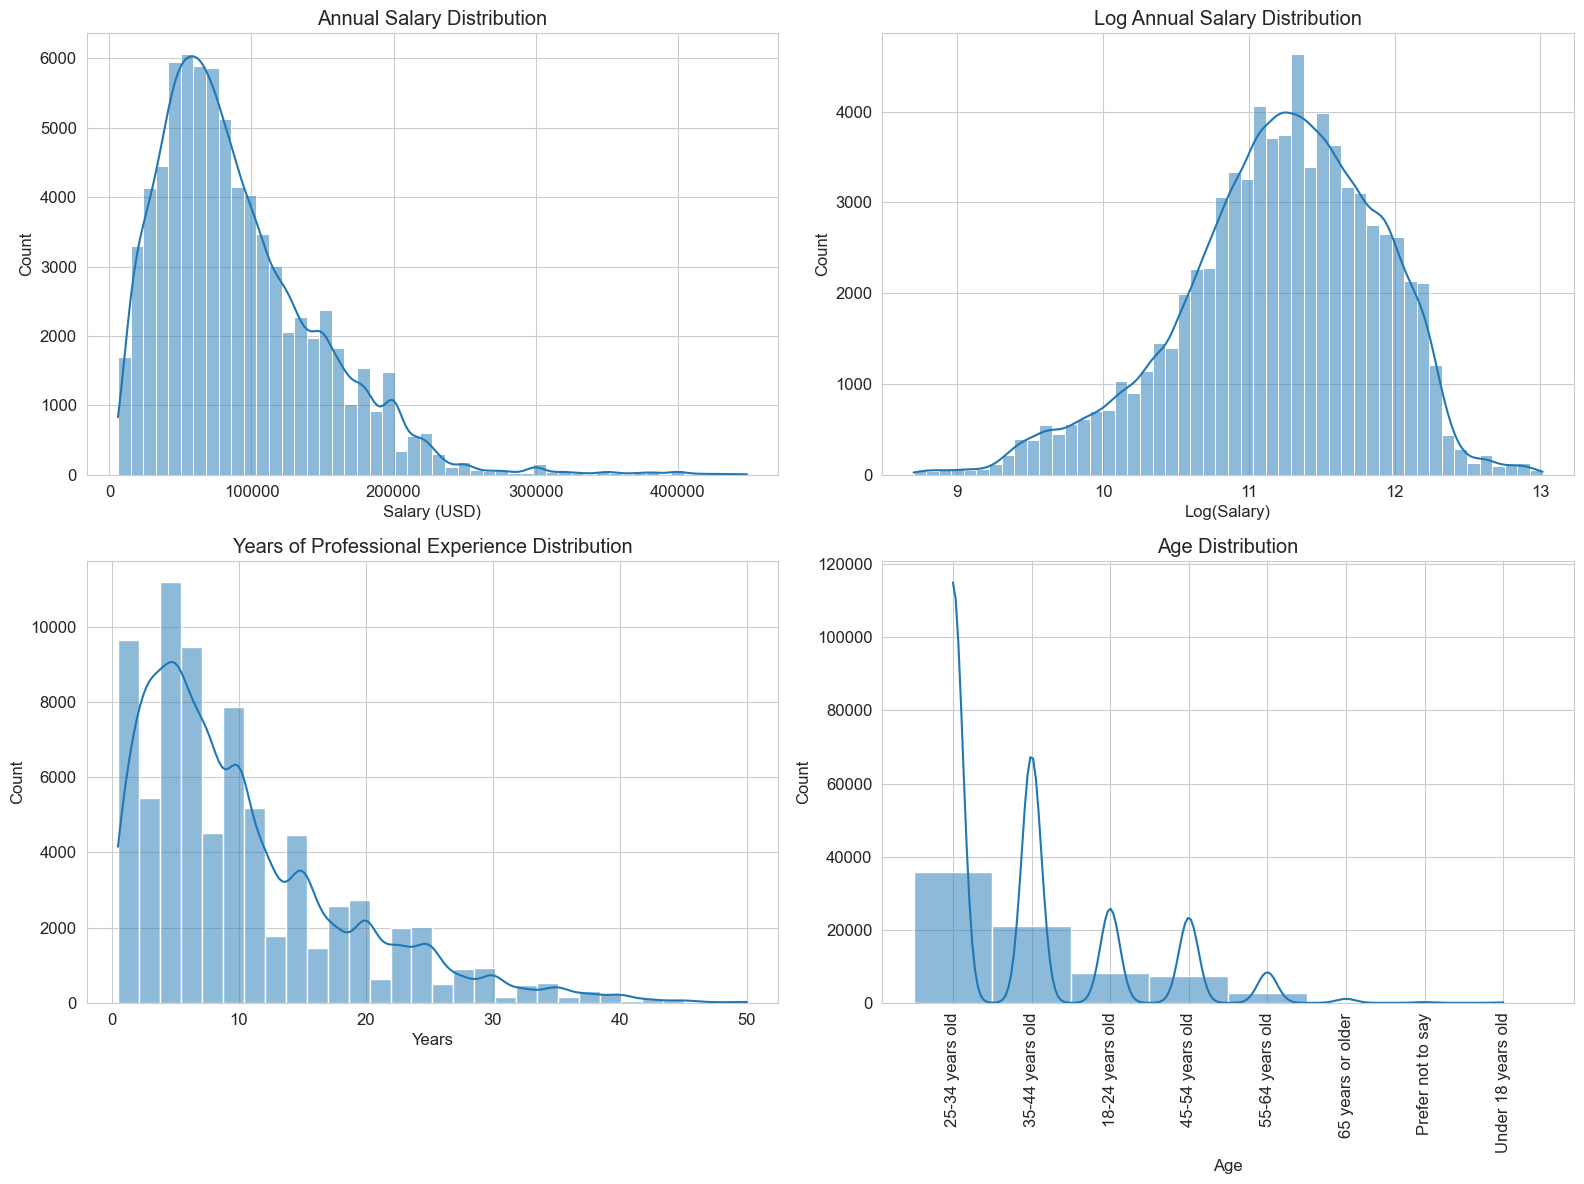

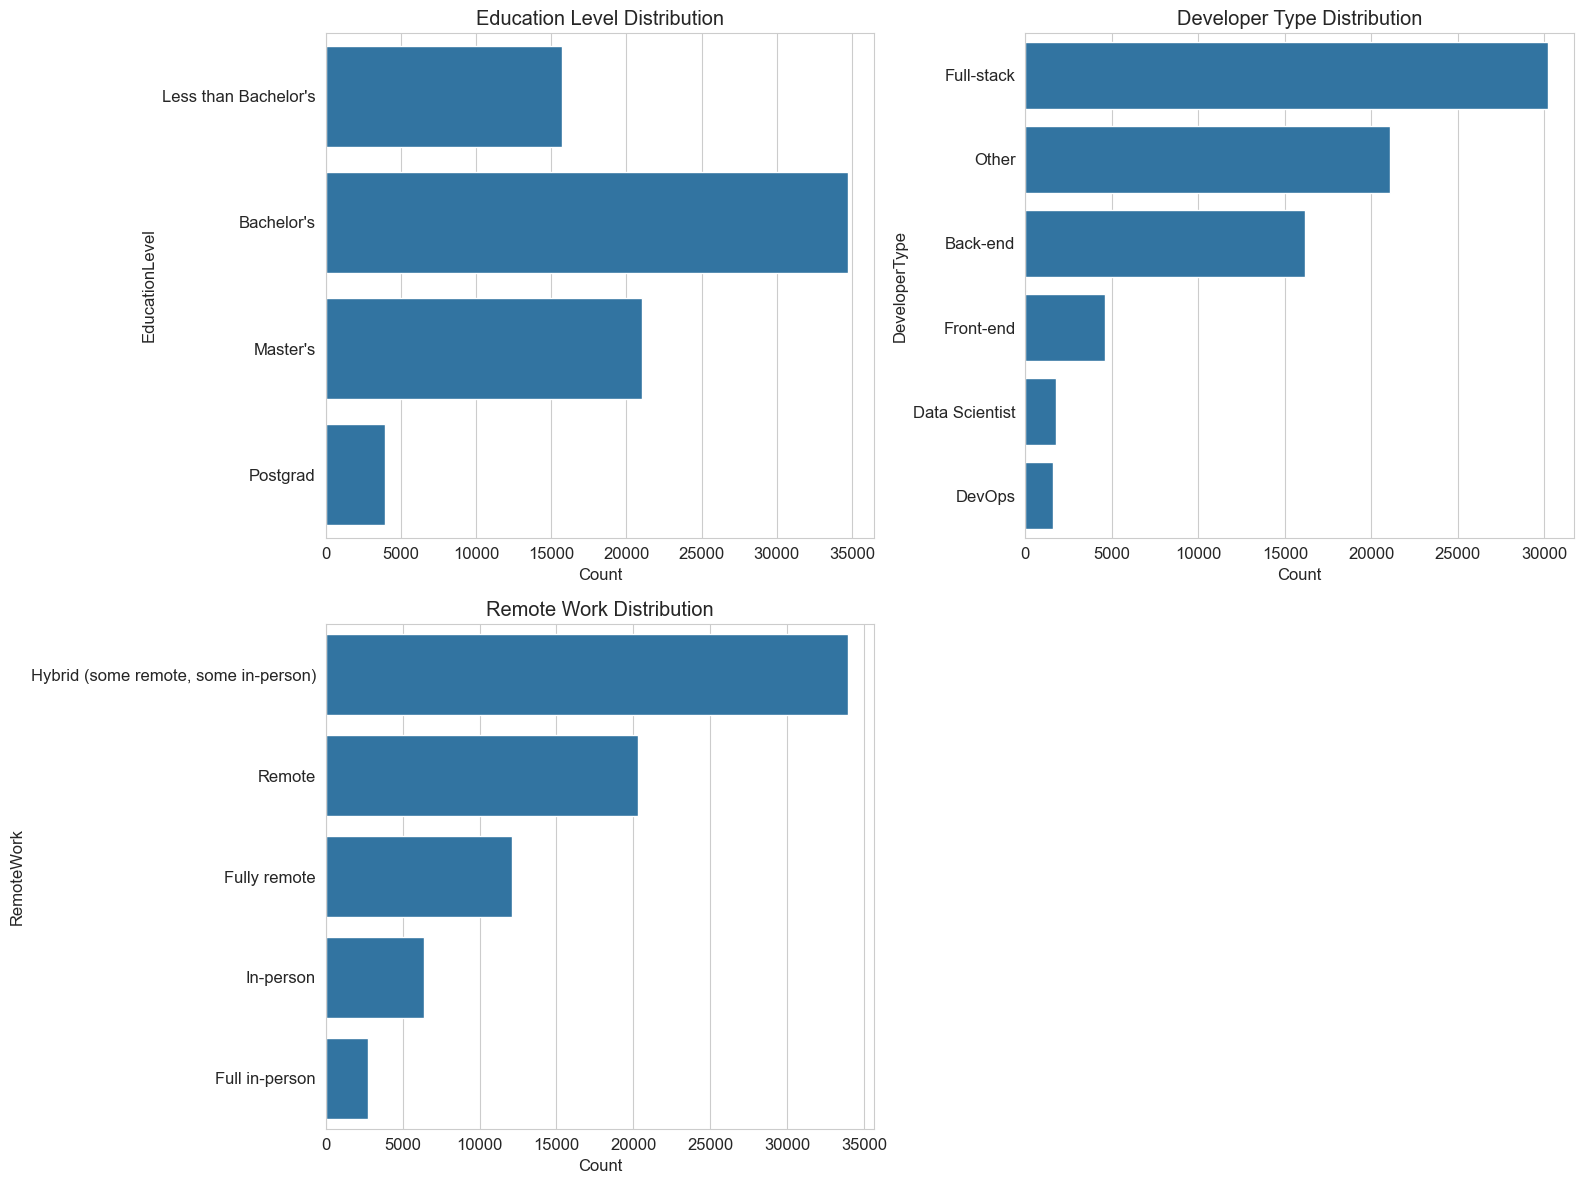

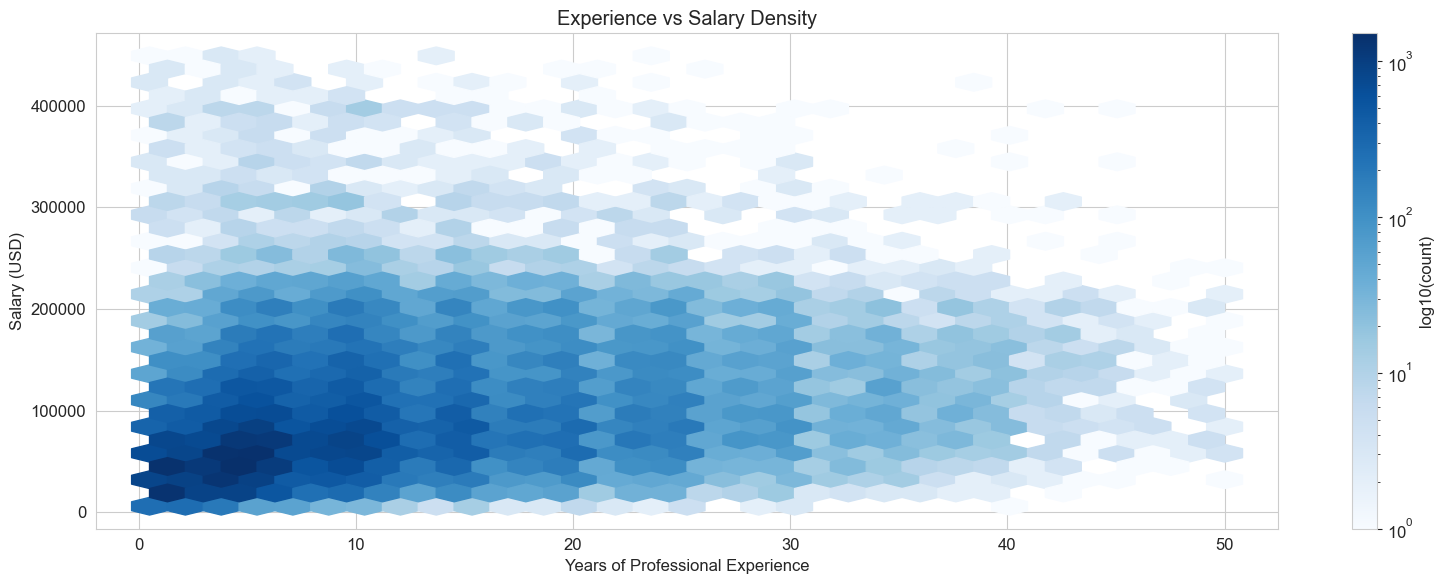

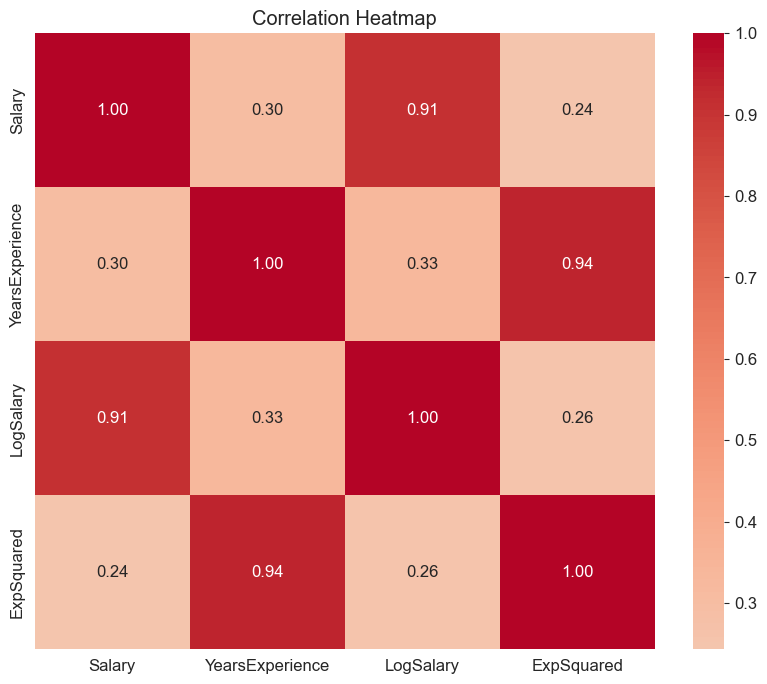

In [8]:
# Set style for better looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

def plot_numerical_distributions(df):
    """Plot distributions for numerical variables"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Salary distribution
    sns.histplot(df['Salary'], bins=50, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Annual Salary Distribution')
    axes[0, 0].set_xlabel('Salary (USD)')
    
    # Log Salary distribution
    sns.histplot(df['LogSalary'], bins=50, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Log Annual Salary Distribution')
    axes[0, 1].set_xlabel('Log(Salary)')
    
    # Years of Experience
    sns.histplot(df['YearsExperience'], bins=30, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Years of Professional Experience Distribution')
    axes[1, 0].set_xlabel('Years')
    
    # Age distribution
    if 'Age' in df.columns:
        sns.histplot(df['Age'], bins=30, kde=True, ax=axes[1, 1])
        axes[1, 1].set_title('Age Distribution')
        plt.xticks(rotation=90)
        axes[1, 1].set_xlabel('Age')
    else:
        fig.delaxes(axes[1, 1])
    
    plt.tight_layout()
    plt.show()


def plot_categorical_distributions(df):
    """Plot distributions for categorical variables"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()  # Flatten to easily index [0], [1], [2], [3]

    plot_idx = 0

    # Education Level
    edu_order = ["Less than Bachelor's", "Bachelor's", "Master's", "Postgrad"]
    sns.countplot(data=df, y='EducationLevel', order=edu_order, ax=axes[plot_idx])
    axes[plot_idx].set_title('Education Level Distribution')
    axes[plot_idx].set_xlabel('Count')
    plot_idx += 1

    # Developer Type
    if 'DeveloperType' in df.columns:
        dev_counts = df['DeveloperType'].value_counts()
        sns.countplot(data=df, y='DeveloperType', order=dev_counts.index, ax=axes[plot_idx])
        axes[plot_idx].set_title('Developer Type Distribution')
        axes[plot_idx].set_xlabel('Count')
        plot_idx += 1

    # Remote Work
    if 'RemoteWork' in df.columns:
        remote_counts = df['RemoteWork'].value_counts()
        sns.countplot(data=df, y='RemoteWork', order=remote_counts.index, ax=axes[plot_idx])
        axes[plot_idx].set_title('Remote Work Distribution')
        axes[plot_idx].set_xlabel('Count')
        plot_idx += 1

    # Remove any unused axes
    for i in range(plot_idx, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


def plot_experience_analysis(df):
    """Analyze relationship between experience and salary using hexbin density plot"""
    fig, ax = plt.subplots(figsize=(16, 6))

    # Clean data
    df_clean = df.dropna(subset=['YearsExperience', 'Salary'])

    # Hexbin plot for density visualization
    hb = ax.hexbin(df_clean['YearsExperience'], df_clean['Salary'], 
                   gridsize=30, cmap='Blues', bins='log')
    ax.set_title('Experience vs Salary Density')
    ax.set_xlabel('Years of Professional Experience')
    ax.set_ylabel('Salary (USD)')

    # Color bar
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('log10(count)')

    plt.tight_layout()
    plt.show()

def plot_correlation_analysis(df):
    numerical_cols = ['Salary', 'YearsExperience', 'LogSalary', 'ExpSquared']
    # Only include truly numeric columns
    df_numeric = df[numerical_cols].select_dtypes(include=[np.number])

    corr = df_numeric.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()


print(data.columns)        # check original columns

def perform_comprehensive_eda(df):
    """Run all EDA visualizations"""
    print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns")
    print("\nMissing values per column:")
    print(df.isnull().sum())

    plot_numerical_distributions(df)
    plot_categorical_distributions(df)
    plot_experience_analysis(df)
    plot_correlation_analysis(df)


perform_comprehensive_eda(data)



# 6. Feature Preparation

In [9]:

features = ['Country', 'EducationLevel', 'YearsExperience', 'ExpSquared']
optional_features = ['DeveloperType', 'CompanySize', 'RemoteWork']
for feat in optional_features:
    if feat in data.columns:
        features.append(feat)

categorical_features = [f for f in features if f not in ['YearsExperience', 'ExpSquared']]
numeric_features = [f for f in features if f in ['YearsExperience', 'ExpSquared']]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', 'passthrough', numeric_features)
])


# 7. Train-Test Split

In [10]:

X = data[features]
y = data['LogSalary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 8. Feature Transformation

In [11]:

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


# 9. Model Training

In [12]:

def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42
    }
    model = XGBRegressor(**params)
    return -np.mean(cross_val_score(model, X_train_processed, y_train, cv=5, scoring='neg_mean_squared_error'))

study = optuna.create_study(direction='minimize')
study.optimize(xgb_objective, n_trials=30)

best_xgb = XGBRegressor(**study.best_params, random_state=42)
best_xgb.fit(X_train_processed, y_train)

rf = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
rf.fit(X_train_processed, y_train)

stack = StackingRegressor(
    estimators=[('xgb', best_xgb), ('rf', rf)],
    final_estimator=RidgeCV()
)
stack.fit(X_train_processed, y_train)


[I 2025-05-09 04:44:00,854] A new study created in memory with name: no-name-d61e4f7a-c2a8-4ca2-afd7-13bae352d882
[I 2025-05-09 04:44:01,622] Trial 0 finished with value: 0.16685286464061208 and parameters: {'n_estimators': 207, 'max_depth': 3, 'learning_rate': 0.20724603763452618, 'subsample': 0.7871226689820972, 'colsample_bytree': 0.8381455069914194}. Best is trial 0 with value: 0.16685286464061208.
[I 2025-05-09 04:44:04,748] Trial 1 finished with value: 0.19484962338359177 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.15742046414332714, 'subsample': 0.7999195954369541, 'colsample_bytree': 0.8505584623201905}. Best is trial 0 with value: 0.16685286464061208.
[I 2025-05-09 04:44:06,105] Trial 2 finished with value: 0.1669034571262641 and parameters: {'n_estimators': 264, 'max_depth': 5, 'learning_rate': 0.10658914613227523, 'subsample': 0.7609092836517685, 'colsample_bytree': 0.8112245895351087}. Best is trial 0 with value: 0.16685286464061208.
[I 2025-05

StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.617634565789948,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            intera...
                                            learning_rate=0.09267956395188531,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=449, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                              ('rf',
                               RandomForestRegressor(max_depth=15,
                                                     n_estimators=200,
                                                     random_state=42))],
                  final_estimator=RidgeCV())

# 10. Model Evaluation


XGBoost Performance:
RMSE (log scale): 0.4087
R² Score: 0.6386
RMSE (USD): $38,900.57


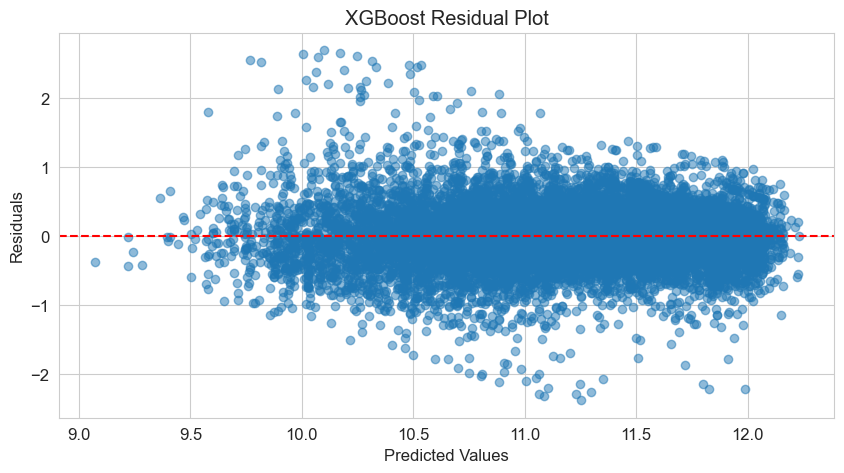


Random Forest Performance:
RMSE (log scale): 0.4350
R² Score: 0.5907
RMSE (USD): $40,146.83


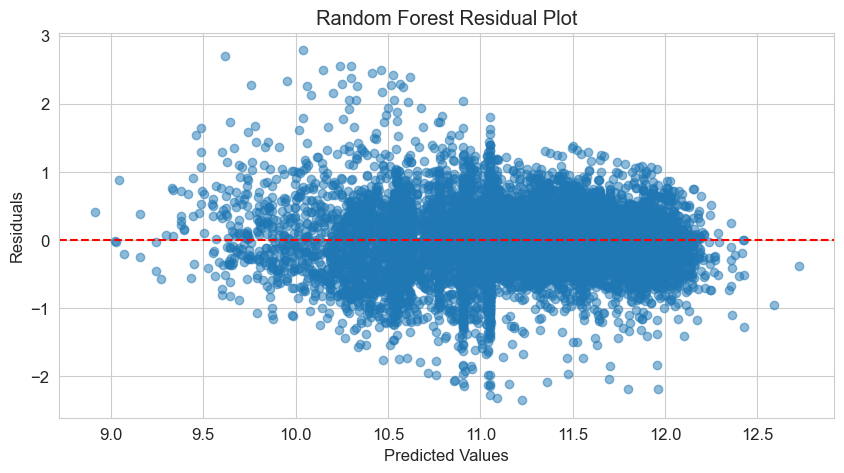


Stacked Model Performance:
RMSE (log scale): 0.4086
R² Score: 0.6387
RMSE (USD): $38,898.98


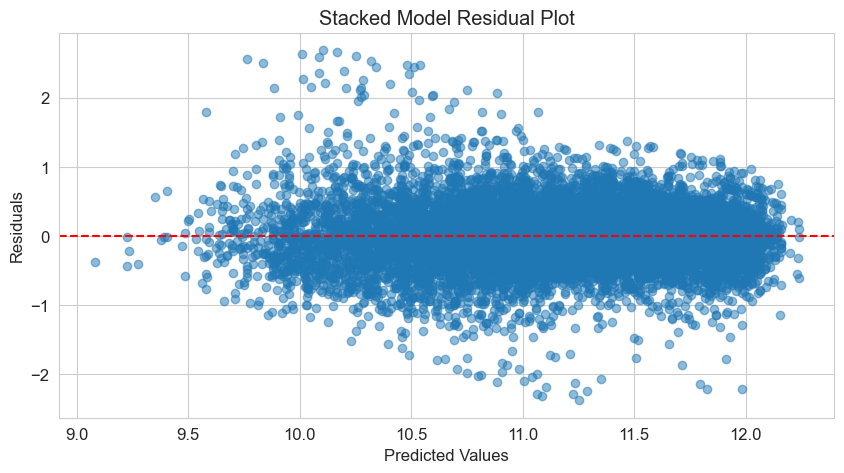

In [13]:

def evaluate_model(name, model, X_test, y_test):
    """Evaluate and visualize model performance."""
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n{name} Performance:")
    print(f"RMSE (log scale): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Convert back to original scale
    y_test_orig = np.expm1(y_test)
    y_pred_orig = np.expm1(y_pred)
    rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    print(f"RMSE (USD): ${rmse_orig:,.2f}")

    # Plot residuals
    plt.figure(figsize=(10, 5))
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'{name} Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()

    return rmse, r2

results = {}
for name, model in [('XGBoost', best_xgb), ('Random Forest', rf), ('Stacked Model', stack)]:
        rmse, r2 = evaluate_model(name, model, X_test_processed, y_test)
        results[name] = {'RMSE': rmse, 'R2': r2}

# 11. Save Models

In [14]:

joblib.dump(stack, "./output/salary_predictor.joblib")
joblib.dump(preprocessor, "./output/preprocessor.joblib")


['./output/preprocessor.joblib']

# 12. Testing

In [16]:
def predict_salary(input_data, model=None, preprocessor=None):
    """Make salary predictions with all required features."""
    try:
        # Use the saved model and preprocessor if not provided
        if model is None:
            model = joblib.load('./output/salary_predictor.joblib')
        if preprocessor is None:
            preprocessor = joblib.load('./output/preprocessor.joblib')

        # Create complete input with all required features
        years_exp = float(input_data.get('YearsExperience', 5))
        input_df = pd.DataFrame([{
            'Country': input_data.get('Country', 'United States'),
            'EducationLevel': input_data.get('EducationLevel', "Bachelor's"),
            'YearsExperience': years_exp,
            'ExpSquared': years_exp**2,  # Auto-calculate squared term
            'DeveloperType': input_data.get('DeveloperType', 'Full-stack'),
            'CompanySize': input_data.get('CompanySize', 'Medium (10-99)'),
            'RemoteWork': input_data.get('RemoteWork', 'Hybrid')
        }])

        processed_input = preprocessor.transform(input_df)
        log_pred = model.predict(processed_input)[0]
        return np.expm1(log_pred)
    except Exception as e:
        print(f"\nPrediction Error: {str(e)}")
        print("Required features: Country, EducationLevel, YearsExperience, [DeveloperType, CompanySize, RemoteWork]")
        return None
# Test prediction
example_input = {
    'Country': 'United States',
    'EducationLevel': "Master's",
    'YearsExperience': 5,
    'DeveloperType': 'Data Scientist',
    'CompanySize': 'Large (100-999)',
    'RemoteWork': 'Remote'
}

predicted_salary = predict_salary(example_input)
if predicted_salary is not None:
    print(f"\nSuccessful Prediction:")
    print(f"Input Features: {example_input}")
    print(f"Predicted Salary: ${predicted_salary:,.2f}")


Successful Prediction:
Input Features: {'Country': 'United States', 'EducationLevel': "Master's", 'YearsExperience': 5, 'DeveloperType': 'Data Scientist', 'CompanySize': 'Large (100-999)', 'RemoteWork': 'Remote'}
Predicted Salary: $63,998.41
